# Transformer encoder pretraining

In [11]:
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import torch

sys.path.append('../../modules/')

from logger_tree_language import get_logger
from models import TransformerClassifier
from masked_language_modeling import train_model_mlm, mask_sequences
from plotting import plot_training_history

logger = get_logger('transformer_encoder_pretraining')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_4_8_1.0_0.00000.npy'

In [3]:
k = 8
q = 4

Load data

In [4]:
q, k, sigma, epsilon, roots, leaves, rho = np.load(DATA_PATH, allow_pickle=True)

# The last index corresponds to the seed that generated the
# data/transition tensors: select one.
seed = 0

shuffled_indices = np.random.choice(range(leaves.shape[0]), leaves.shape[0])

roots = roots[:, seed]
roots = roots[shuffled_indices]

leaves = leaves[..., seed].T
leaves = leaves[shuffled_indices, :]
rho = rho[..., seed]

Generate a vocabulary.

In [5]:
vocab = torch.arange(q).to(dtype=torch.int64)
mask_idx = vocab.max() + 1

# Enalarge the vocabulary with the special tokens.
vocab = torch.hstack([vocab, torch.Tensor(mask_idx).to(dtype=torch.int64)])

vocab

tensor([0, 1, 2, 3, 4])

Data preprocessing.

In [6]:
leaves = torch.from_numpy(leaves).to(device=device).to(dtype=torch.int64)

Define model.

In [33]:
seq_len = 2 ** k
embedding_size = 128
vocab_size = vocab.shape[0]

model = TransformerClassifier(
    seq_len=seq_len,
    embedding_size=embedding_size,
    n_tranformer_layers=2,  # Good: 4
    n_heads=1,
    vocab_size=vocab_size,
    encoder_dim_feedforward=2 * embedding_size,
    positional_encoding=False,
    n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
    embedding_agg=None,
    decoder_hidden_sizes=[64],  # Good: [64]
    decoder_activation='relu',  # Good: 'relu'
    decoder_output_activation='identity'
).to(device=device)

/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


2024-04-23 14:59:02,138 - transformer_encoder_pretraining - INFO - Training model
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.65it/s, training_accuracy=tensor(0.4669), training_loss=tensor(1.2680)]
2024-04-23 15:00:02,192 - transformer_encoder_pretraining - INFO - Last epoch: 1000


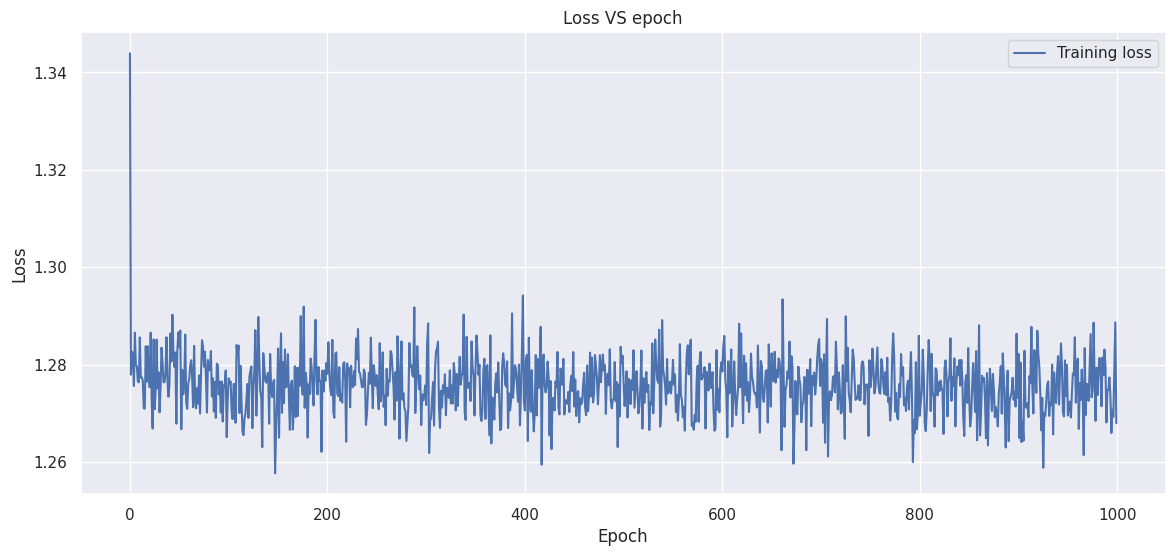

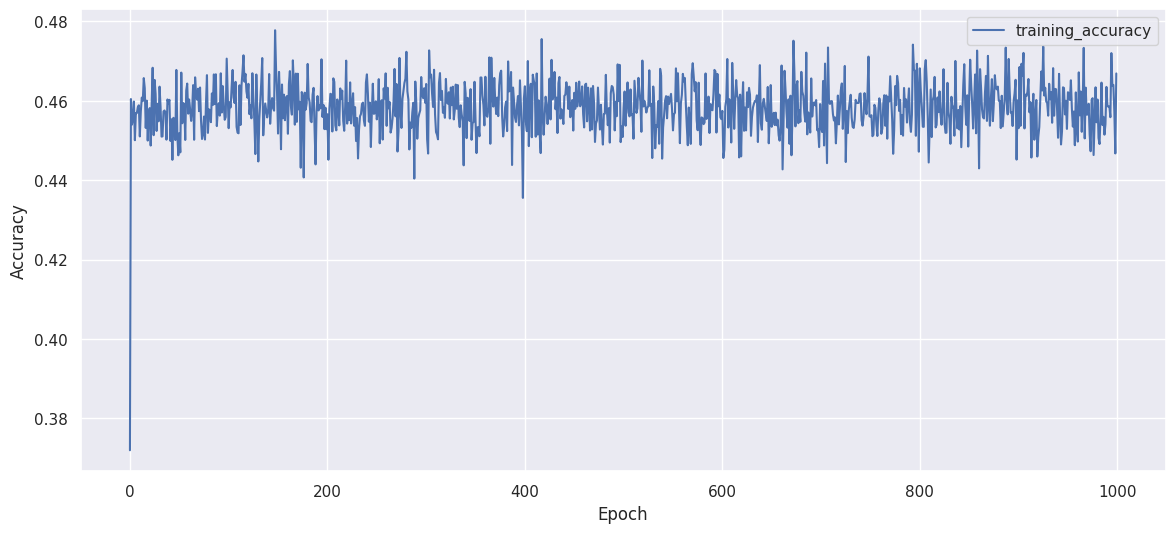

In [34]:
model, training_history = train_model_mlm(
    sequences=leaves,
    model=model,
    n_epochs=1000,
    learning_rate=1e-4,
    batch_size=32,
    mask_rate=0.1,
    mask_idx=mask_idx,
    device=device
)

plot_training_history(training_history)